In [1]:
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from collections import defaultdict
from scipy.stats import binom

In [ ]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from scipy.stats import binom

# ============================================================
# 🔧 Helper Functions
# ============================================================

def smooth(values, window_size=5):
    """Centered moving average smoothing."""
    if len(values) < window_size:
        return np.array(values)
    s = pd.Series(values)
    return s.rolling(window=window_size, min_periods=1, center=True).mean().to_numpy()

def tol_interval(arr2d, beta=0.9, alpha=0.05):
    """Distribution-free (α, β) tolerance interval for variation across runs."""
    n = arr2d.shape[0]
    if n <= 1:
        return arr2d[0], arr2d[0]
    ν = int(binom.ppf(alpha, n, 1 - beta))
    l = int(np.floor(ν / 2))
    u = int(np.ceil(n - ν / 2))
    sorted_ = np.sort(arr2d, axis=0)
    return sorted_[l], sorted_[min(u - 1, n - 1)]

def extract_ppo_params(fn):
    """Extract PPO hyperparameters for legend labels."""
    c = re.search(r"clip_param=([\d\.]+)", fn)
    kl = re.search(r"target_kl=([\d\.]+)", fn)
    pi = re.search(r"train_policy_iters=(\d+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    return f"clip={c.group(1) if c else '?'}, kl={kl.group(1) if kl else '?'}, pi={pi.group(1) if pi else '?'}, vf={vf.group(1) if vf else '?'}"

# ============================================================
# 🚀 PPO Offline Rollout Analysis
# ============================================================

def analyze_ppo_offline_logs(
    log_dir,
    env_name="Unknown Environment",
    beta=0.9,
    alpha=0.05,
    window_size=5,
    figsize=(10, 6),
    save_fig=False,
):
    """
    Plot PPO offline rollout performance with mean curve + tolerance interval.

    Parameters
    ----------
    log_dir : str or Path
        Folder containing PPO JSON logs with 'evaluation' events.
    env_name : str
        Environment name (e.g. 'Ant-v5').
    beta : float
        Proportion of population coverage (default 0.9).
    alpha : float
        Confidence level complement (default 0.05 → 95 % confidence).
    window_size : int
        Rolling-window size for smoothing the mean curve.
    figsize : tuple
        Matplotlib figure size.
    save_fig : bool
        If True, save the figure as PNG in the same folder.
    """

    # ------------------------------------------------------------
    # Step 1. Load evaluation data
    # ------------------------------------------------------------
    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    if not files:
        raise FileNotFoundError(f"No PPO logs found in {folder}")
    print(f"📂 Found {len(files)} PPO log files in {folder}")

    cfg_groups = defaultdict(list)

    for p in files:
        try:
            with p.open("r") as f:
                d = json.load(f)
            evals = [e for e in d.get("events", []) if e.get("event") == "evaluation"]
            if not evals:
                continue
            steps = np.array([e.get("total_steps", np.nan) for e in evals])
            avg = np.array([e.get("average_return", np.nan) for e in evals])
            cfg = re.sub(r"_seed=\d+", "", p.name)
            cfg_groups[cfg].append((steps, avg))
        except Exception as e:
            print(f"⚠️ {p.name}: {e}")

    print(f"✅ Found {len(cfg_groups)} unique PPO configurations.\n")

    # ------------------------------------------------------------
    # Step 2. Aggregate across independent runs
    # ------------------------------------------------------------
    curves, ranking = {}, []
    for cfg, runs in cfg_groups.items():
        if not runs:
            continue

        # Unified grid over all evaluation steps
        all_steps = sorted(set(np.concatenate([r[0] for r in runs])))
        all_curves = []
        for steps, avg in runs:
            interp = np.interp(all_steps, steps, avg, left=np.nan, right=np.nan)
            smoothed = smooth(interp, window_size)
            all_curves.append(smoothed)
        all_curves = np.array(all_curves)

        mean_curve = np.nanmean(all_curves, axis=0)
        low, up = tol_interval(all_curves, beta, alpha)

        curves[cfg] = dict(steps=np.array(all_steps), mean=mean_curve, low=low, up=up)

        # Use final offline eval for ranking
        final_vals = [avg[-1] for _, avg in runs if len(avg) > 0]
        mean_final = np.mean(final_vals)
        std_final = np.std(final_vals)
        ranking.append((extract_ppo_params(cfg), mean_final, std_final, mean_final / (std_final + 1e-8)))

    # ------------------------------------------------------------
    # Step 3. Ranking table
    # ------------------------------------------------------------
    ranking.sort(key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(ranking, columns=["Config", "Mean Final", "Std Final", "Mean/Std"])
    print(f"📊 PPO Offline Evaluation Results ({env_name}):\n")
    print(df.to_string(index=False, justify="left", formatters={
        "Mean Final": "{:,.2f}".format,
        "Std Final": "{:,.2f}".format,
        "Mean/Std": "{:,.2f}".format
    }))

    # ------------------------------------------------------------
    # Step 4. Plot learning curves per config (no overall mean)
    # ------------------------------------------------------------
    plt.figure(figsize=figsize)
    for i, (cfg, data) in enumerate(curves.items()):
        c = f"C{i%10}"
        label = extract_ppo_params(cfg)
        plt.plot(data["steps"], data["mean"], color=c, lw=2.2, label=label)
        plt.fill_between(data["steps"], data["low"], data["up"], color=c, alpha=0.15)

    plt.title(
        f"PPO Offline Rollout Performance – {env_name}\n(α = {alpha}, β = {beta})",
        fontsize=14, weight="bold", pad=10
    )
    plt.xlabel("Training Steps")
    plt.ylabel("Average Offline Return")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend(fontsize=8, frameon=False, loc="lower right")
    plt.tight_layout()

    if save_fig:
        out_path = folder / f"PPO_Offline_{env_name.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()
    return df, curves


📂 Found 32 PPO log files in \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\Analysis
✅ Found 16 unique PPO configurations.

📊 PPO Offline Evaluation Results (Ant-v5 (Offline PPO)):

Config                          Mean Final Std Final Mean/Std
clip=0.3, kl=0.02, pi=10, vf=10 2,039.47   300.32     6.79   
clip=0.2, kl=0.01, pi=20, vf=20 1,838.06    28.76    63.91   
clip=0.3, kl=0.02, pi=20, vf=10 1,832.68   306.63     5.98   
clip=0.2, kl=0.02, pi=10, vf=10 1,812.60   141.32    12.83   
clip=0.3, kl=0.01, pi=10, vf=10 1,804.76    30.63    58.91   
clip=0.3, kl=0.02, pi=20, vf=20 1,777.52    80.99    21.95   
clip=0.3, kl=0.02, pi=10, vf=20 1,760.06    48.82    36.05   
clip=0.2, kl=0.01, pi=10, vf=20 1,751.93    37.13    47.18   
clip=0.2, kl=0.02, pi=20, vf=20 1,743.26   212.76     8.19   
clip=0.2, kl=0.01, pi=20, vf=10 1,742.31   121.93    14.29   
clip=0.3, kl=0.01, pi=20, vf=10 1,725.09   110.31    15.64   
clip=0.2, kl=0.01, pi=10, vf=10 1,611.44    67.58    23

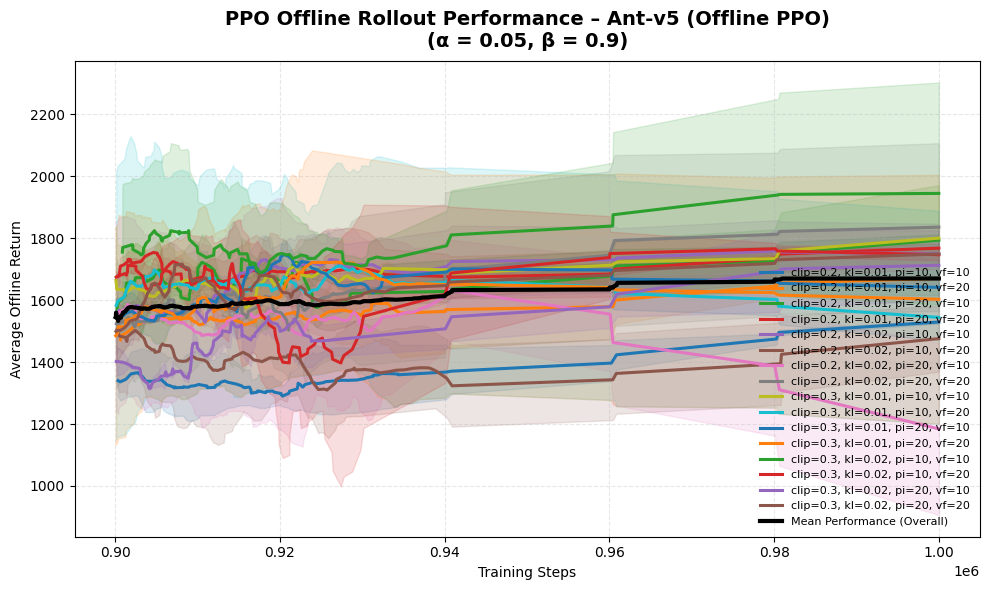

In [19]:
df_offline, curves_offline = analyze_ppo_offline_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/Analysis",
    env_name="Ant-v5 (Offline PPO)",
    window_size=5,
    beta=0.9,
    alpha=0.05
)


In [20]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from scipy.stats import binom

# ============================================================
# 🔧 Helper Functions
# ============================================================

def smooth(v, w=5):
    """Centered moving average smoothing (for visual continuity)."""
    if len(v) < w:
        return np.array(v)
    s = pd.Series(v)
    return s.rolling(window=w, min_periods=1, center=True).mean().to_numpy()

def tol_interval(arr2d, beta=0.9, alpha=0.05):
    """Distribution-free tolerance interval (nonparametric)."""
    n = arr2d.shape[0]
    if n <= 1:
        return arr2d[0], arr2d[0]
    ν = int(binom.ppf(alpha, n, 1 - beta))
    l = int(np.floor(ν / 2))
    u = int(np.ceil(n - ν / 2))
    sorted_ = np.sort(arr2d, axis=0)
    return sorted_[l], sorted_[min(u - 1, n - 1)]

def extract_ppo_params(fn):
    """Extract PPO hyperparameters from filename for legend labels."""
    c = re.search(r"clip_param=([\d\.]+)", fn)
    kl = re.search(r"target_kl=([\d\.]+)", fn)
    pi = re.search(r"train_policy_iters=(\d+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    return f"clip={c.group(1) if c else '?'}, kl={kl.group(1) if kl else '?'}, pi={pi.group(1) if pi else '?'}, vf={vf.group(1) if vf else '?'}"


# ============================================================
# 🚀 PPO Offline Rollout Analysis
# ============================================================
def analyze_ppo_offline_logs(
    log_dir,
    env_name="Unknown Environment",
    beta=0.9,
    alpha=0.05,
    subtitle=None,
    figsize=(12, 7),
    save_fig=False,
):
    """
    Analyze PPO offline rollout evaluation logs and plot mean + tolerance intervals.

    Parameters
    ----------
    log_dir : str or Path
        Directory containing PPO JSON log files.
    env_name : str
        Environment name (e.g., 'Ant-v5', 'HalfCheetah-v5').
    beta : float
        Coverage proportion (e.g., 0.9 means cover 90% of agents).
    alpha : float
        Significance level (e.g., 0.05 means 95% confidence).
    subtitle : str
        Optional subtitle for the figure.
    figsize : tuple
        Figure size for the single-panel plot.
    save_fig : bool
        If True, saves the figure in the same directory.
    """

    # --------------------------------------------------------
    # 🗂️ Load logs
    # --------------------------------------------------------
    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    print(f"Found {len(files)} PPO offline logs.")
    if not files:
        raise FileNotFoundError("No PPO log files found!")

    cfg_groups = defaultdict(list)

    for fpath in files:
        try:
            with fpath.open("r") as f:
                data = json.load(f)
            evals = [e for e in data.get("events", []) if e.get("event") == "evaluation"]
            if not evals:
                continue

            steps = np.array([e.get("total_steps", np.nan) for e in evals])
            avg_returns = np.array([e.get("average_return", np.nan) for e in evals])

            cfg = re.sub(r"_seed=\d+", "", fpath.name)
            cfg_groups[cfg].append(pd.DataFrame({"steps": steps, "avg": avg_returns}))
        except Exception as e:
            print(f"⚠️ {fpath.name}: {e}")

    print(f"Found {len(cfg_groups)} unique PPO configs with offline evaluations.\n")

    # --------------------------------------------------------
    # 📊 Aggregate across seeds and compute statistics
    # --------------------------------------------------------
    results = {}
    ranking = []

    for cfg, dfs in cfg_groups.items():
        if len(dfs) == 0:
            continue

        combined = pd.concat(dfs, ignore_index=True).sort_values("steps")
        unique_steps = np.unique(combined["steps"])
        all_seeds = []

        for df in dfs:
            interp = np.interp(unique_steps, df["steps"], df["avg"], left=np.nan, right=np.nan)
            all_seeds.append(interp)

        all_seeds = np.array(all_seeds)
        mean_curve = np.nanmean(all_seeds, axis=0)
        low, up = tol_interval(all_seeds, beta=beta, alpha=alpha)

        results[cfg] = dict(steps=unique_steps, mean=mean_curve, low=low, up=up)
        mean_perf = np.nanmean(mean_curve)
        std_perf = np.nanstd(mean_curve)
        ranking.append((extract_ppo_params(cfg), mean_perf, std_perf, mean_perf / (std_perf + 1e-8)))

    # --------------------------------------------------------
    # 🧮 Ranking Table
    # --------------------------------------------------------
    ranking.sort(key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(ranking, columns=["Config", "Mean", "Std", "Mean/Std"])
    print(f"📊 PPO Offline Evaluation Ranking – {env_name}\n")
    print(df.to_string(index=False, justify="left", formatters={
        "Mean": "{:,.2f}".format,
        "Std": "{:,.2f}".format,
        "Mean/Std": "{:,.2f}".format,
    }))

    # --------------------------------------------------------
    # 🎨 Plotting
    # --------------------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    title_text = f"PPO Offline Rollout Performance – {env_name}"
    if subtitle:
        title_text += f"\n{subtitle}"
    fig.suptitle(title_text, fontsize=16, weight="bold", y=0.98)
    ax.set_title(f"(α = {alpha}, β = {beta})", fontsize=11, pad=6)

    for i, (cfg, data) in enumerate(results.items()):
        c = f"C{i % 10}"
        label = extract_ppo_params(cfg)
        ax.plot(data["steps"], smooth(data["mean"], 3), color=c, lw=1.8, label=label)
        ax.fill_between(data["steps"], data["low"], data["up"], color=c, alpha=0.15)

    ax.set_xlabel("Training Steps")
    ax.set_ylabel("Average Offline Return")
    ax.grid(alpha=0.3, linestyle="--")
    ax.ticklabel_format(style="plain", axis="x")

    h, l = ax.get_legend_handles_labels()
    fig.legend(h, l, loc="lower center", ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(rect=[0, 0.06, 1, 0.95])

    if save_fig:
        out_path = folder / f"PPO_Offline_{env_name.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()
    return df, results


In [24]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from scipy.stats import binom

# ============================================================
# 🔧 Helper Functions
# ============================================================

def smooth(v, w=5):
    """Centered moving average smoothing."""
    if len(v) < w:
        return np.array(v)
    s = pd.Series(v)
    return s.rolling(window=w, min_periods=1, center=True).mean().to_numpy()

def tol_interval(arr2d, beta=0.9, alpha=0.05):
    """Distribution-free (α, β) tolerance interval."""
    n = arr2d.shape[0]
    if n <= 1:
        return arr2d[0], arr2d[0]
    ν = int(binom.ppf(alpha, n, 1 - beta))
    l = int(np.floor(ν / 2))
    u = int(np.ceil(n - ν / 2))
    sorted_ = np.sort(arr2d, axis=0)
    return sorted_[l], sorted_[min(u - 1, n - 1)]

def extract_trpo_params(fn):
    """Extract TRPO hyperparameters from filename for legend labels."""
    d = re.search(r"delta=([\d\.]+)", fn)
    c = re.search(r"backtrack_coeff=([\d\.]+)", fn)
    vf = re.search(r"train_vf_iters=(\d+)", fn)
    a = re.search(r"backtrack_alpha=([\d\.]+)", fn)
    return f"δ={d.group(1) if d else '?'}, coeff={c.group(1) if c else '?'}, vf={vf.group(1) if vf else '?'}, α={a.group(1) if a else '?'}"


# ============================================================
# 🚀 TRPO Offline Rollout Analysis
# ============================================================
def analyze_trpo_offline_logs(
    log_dir,
    env_name="Unknown Environment",
    beta=0.9,
    alpha=0.05,
    subtitle=None,
    figsize=(12, 7),
    save_fig=False,
):
    """
    Analyze TRPO offline rollout logs and plot mean + tolerance intervals.

    Parameters
    ----------
    log_dir : str or Path
        Directory containing TRPO JSON log files.
    env_name : str
        Environment name (e.g., 'Ant-v5', 'HalfCheetah-v5').
    beta : float
        Coverage proportion (e.g., 0.9 means 90% of agents).
    alpha : float
        Significance level (e.g., 0.05 means 95% confidence).
    subtitle : str
        Optional subtitle for figure.
    figsize : tuple
        Figure size for plot.
    save_fig : bool
        Whether to save figure to log_dir.
    """

    # --------------------------------------------------------
    # 🗂️ Load logs
    # --------------------------------------------------------
    folder = Path(r"\\?\\" + str(Path(log_dir).resolve()))
    files = list(folder.glob("*.json")) + list(folder.glob("*.jso"))
    print(f"Found {len(files)} TRPO offline logs.")
    if not files:
        raise FileNotFoundError("No TRPO log files found!")

    cfg_groups = defaultdict(list)

    for fpath in files:
        try:
            with fpath.open("r") as f:
                data = json.load(f)
            evals = [e for e in data.get("events", []) if e.get("event") == "evaluation"]
            if not evals:
                continue

            steps = np.array([e.get("total_steps", np.nan) for e in evals])
            avg_returns = np.array([e.get("average_return", np.nan) for e in evals])

            cfg = re.sub(r"_seed=\d+", "", fpath.name)
            cfg_groups[cfg].append(pd.DataFrame({"steps": steps, "avg": avg_returns}))
        except Exception as e:
            print(f"⚠️ {fpath.name}: {e}")

    print(f"Found {len(cfg_groups)} unique TRPO configs with offline evaluations.\n")

    # --------------------------------------------------------
    # 📊 Aggregate across seeds and compute statistics
    # --------------------------------------------------------
    results = {}
    ranking = []

    for cfg, dfs in cfg_groups.items():
        if len(dfs) == 0:
            continue

        combined = pd.concat(dfs, ignore_index=True).sort_values("steps")
        unique_steps = np.unique(combined["steps"])
        all_seeds = []

        for df in dfs:
            interp = np.interp(unique_steps, df["steps"], df["avg"], left=np.nan, right=np.nan)
            all_seeds.append(interp)

        all_seeds = np.array(all_seeds)
        mean_curve = np.nanmean(all_seeds, axis=0)
        low, up = tol_interval(all_seeds, beta=beta, alpha=alpha)

        results[cfg] = dict(steps=unique_steps, mean=mean_curve, low=low, up=up)
        mean_perf = np.nanmean(mean_curve)
        std_perf = np.nanstd(mean_curve)
        ranking.append((extract_trpo_params(cfg), mean_perf, std_perf, mean_perf / (std_perf + 1e-8)))

    # --------------------------------------------------------
    # 🧮 Ranking Table
    # --------------------------------------------------------
    ranking.sort(key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(ranking, columns=["Config", "Mean", "Std", "Mean/Std"])
    print(f"📊 TRPO Offline Evaluation Ranking – {env_name}\n")
    print(df.to_string(index=False, justify="left", formatters={
        "Mean": "{:,.2f}".format,
        "Std": "{:,.2f}".format,
        "Mean/Std": "{:,.2f}".format,
    }))

    # --------------------------------------------------------
    # 🎨 Plotting
    # --------------------------------------------------------
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    title_text = f"TRPO Offline Rollout Performance – {env_name}"
    if subtitle:
        title_text += f"\n{subtitle}"
    fig.suptitle(title_text, fontsize=16, weight="bold", y=0.98)
    ax.set_title(f"(α = {alpha}, β = {beta})", fontsize=11, pad=6)

    for i, (cfg, data) in enumerate(results.items()):
        c = f"C{i % 10}"
        label = extract_trpo_params(cfg)
        ax.plot(data["steps"], smooth(data["mean"], 3), color=c, lw=1.8, label=label)
        ax.fill_between(data["steps"], data["low"], data["up"], color=c, alpha=0.15)

    ax.set_xlabel("Training Steps")
    ax.set_ylabel("Average Offline Return")
    ax.grid(alpha=0.3, linestyle="--")
    ax.ticklabel_format(style="plain", axis="x")

    h, l = ax.get_legend_handles_labels()
    fig.legend(h, l, loc="lower center", ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(rect=[0, 0.06, 1, 0.95])

    if save_fig:
        out_path = folder / f"TRPO_Offline_{env_name.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print(f"💾 Saved figure to: {out_path}")

    plt.show()
    return df, results


Found 24 TRPO offline logs.
Found 12 unique TRPO configs with offline evaluations.

📊 TRPO Offline Evaluation Ranking – HalfCheetah-v5

Config                           Mean     Std    Mean/Std
   δ=0.02, coeff=1, vf=80, α=0.5 2,355.67 111.73 21.08   
   δ=0.01, coeff=1, vf=10, α=0.5 2,304.71  82.76 27.85   
 δ=0.01, coeff=0.8, vf=10, α=0.5 2,280.67 167.33 13.63   
   δ=0.02, coeff=1, vf=10, α=0.5 2,262.31 213.48 10.60   
 δ=0.02, coeff=0.8, vf=80, α=0.5 2,171.02 191.01 11.37   
  δ=0.01, coeff=1, vf=120, α=0.5 2,011.10 139.93 14.37   
δ=0.02, coeff=0.8, vf=120, α=0.5 1,768.37 245.83  7.19   
 δ=0.01, coeff=0.8, vf=80, α=0.5 1,737.32 170.11 10.21   
 δ=0.02, coeff=0.8, vf=10, α=0.5 1,660.00 107.42 15.45   
δ=0.01, coeff=0.8, vf=120, α=0.5 1,620.23  25.43 63.73   
   δ=0.01, coeff=1, vf=80, α=0.5 1,542.25  47.75 32.30   
  δ=0.02, coeff=1, vf=120, α=0.5 1,349.99 174.23  7.75   
💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_chet\TRPO_Offline_H

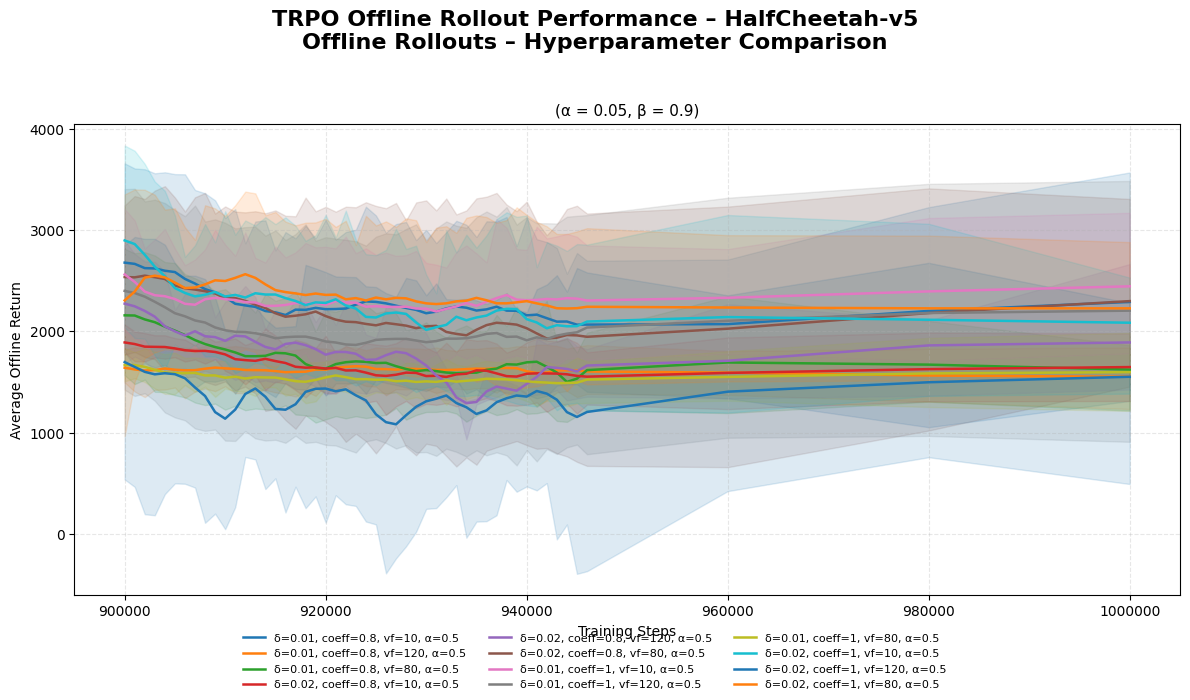

Found 32 PPO offline logs.
Found 16 unique PPO configs with offline evaluations.

📊 PPO Offline Evaluation Ranking – HalfCheetah-v5

Config                          Mean     Std    Mean/Std
clip=0.3, kl=0.02, pi=10, vf=10 3,298.05 387.25  8.52   
clip=0.3, kl=0.02, pi=20, vf=20 3,147.07 176.70 17.81   
clip=0.3, kl=0.02, pi=20, vf=10 2,835.67 101.80 27.86   
clip=0.2, kl=0.02, pi=20, vf=10 2,745.48 227.91 12.05   
clip=0.2, kl=0.01, pi=20, vf=20 2,657.21 182.12 14.59   
clip=0.3, kl=0.01, pi=20, vf=10 2,573.99 102.59 25.09   
clip=0.2, kl=0.02, pi=10, vf=20 2,533.62 125.77 20.15   
clip=0.2, kl=0.01, pi=10, vf=20 2,521.22  73.43 34.34   
clip=0.3, kl=0.01, pi=10, vf=20 2,406.40 290.58  8.28   
clip=0.3, kl=0.01, pi=10, vf=10 2,287.67 313.31  7.30   
clip=0.2, kl=0.02, pi=20, vf=20 2,008.03 491.91  4.08   
clip=0.3, kl=0.01, pi=20, vf=20 1,981.21 277.84  7.13   
clip=0.3, kl=0.02, pi=10, vf=20 1,957.72 116.52 16.80   
clip=0.2, kl=0.01, pi=20, vf=10 1,934.56  77.16 25.07   
clip=0.2, kl

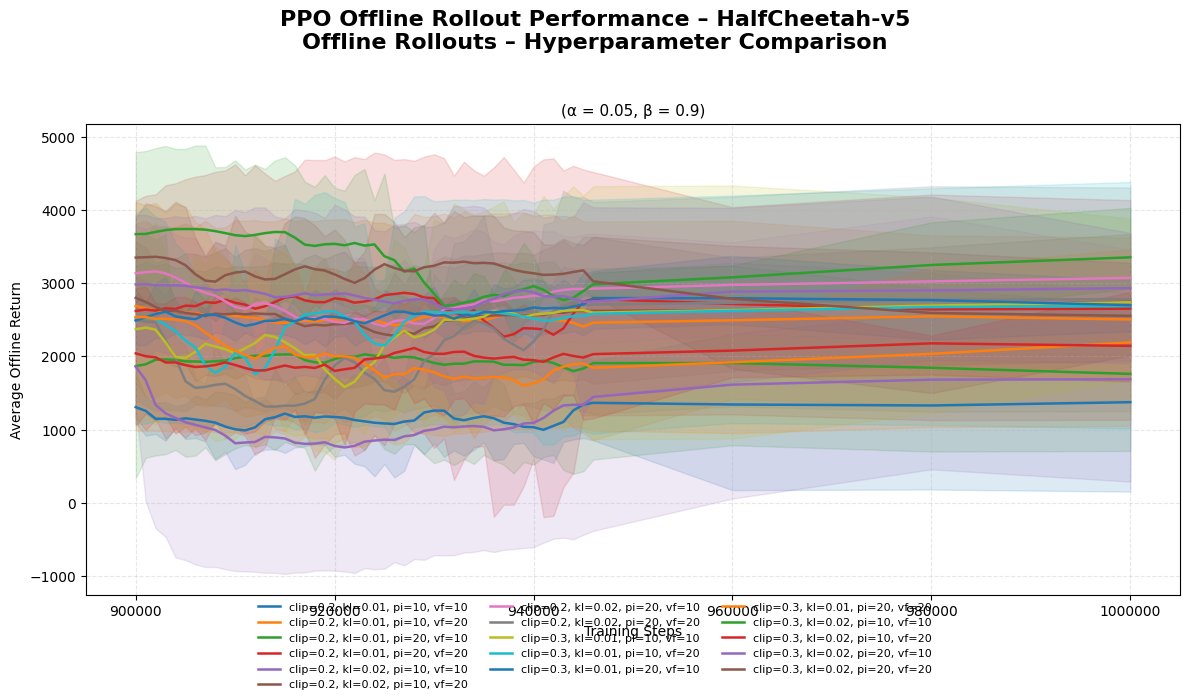

Found 24 TRPO offline logs.
Found 12 unique TRPO configs with offline evaluations.

📊 TRPO Offline Evaluation Ranking – Ant-v5

Config                           Mean     Std   Mean/Std
 δ=0.02, coeff=0.8, vf=10, α=0.5 1,296.84 45.58 28.45   
   δ=0.01, coeff=1, vf=10, α=0.5 1,209.29 41.89 28.87   
 δ=0.01, coeff=0.8, vf=10, α=0.5 1,171.25 57.61 20.33   
   δ=0.02, coeff=1, vf=10, α=0.5 1,091.19 18.55 58.83   
 δ=0.01, coeff=0.8, vf=80, α=0.5   980.40 17.05 57.51   
δ=0.01, coeff=0.8, vf=120, α=0.5   938.30 41.00 22.89   
   δ=0.01, coeff=1, vf=80, α=0.5   839.16 35.50 23.64   
 δ=0.02, coeff=0.8, vf=80, α=0.5   812.86 36.00 22.58   
   δ=0.02, coeff=1, vf=80, α=0.5   796.41 28.65 27.80   
  δ=0.01, coeff=1, vf=120, α=0.5   742.84 21.10 35.20   
δ=0.02, coeff=0.8, vf=120, α=0.5   687.34 21.51 31.95   
  δ=0.02, coeff=1, vf=120, α=0.5   440.89 20.65 21.35   
💾 Saved figure to: \\?\\C:\Users\Phong\OneDrive\Documents\VSCODEFILE\CMPUT665-PROJECT\trpo_ant\TRPO_Offline_Ant-v5.png


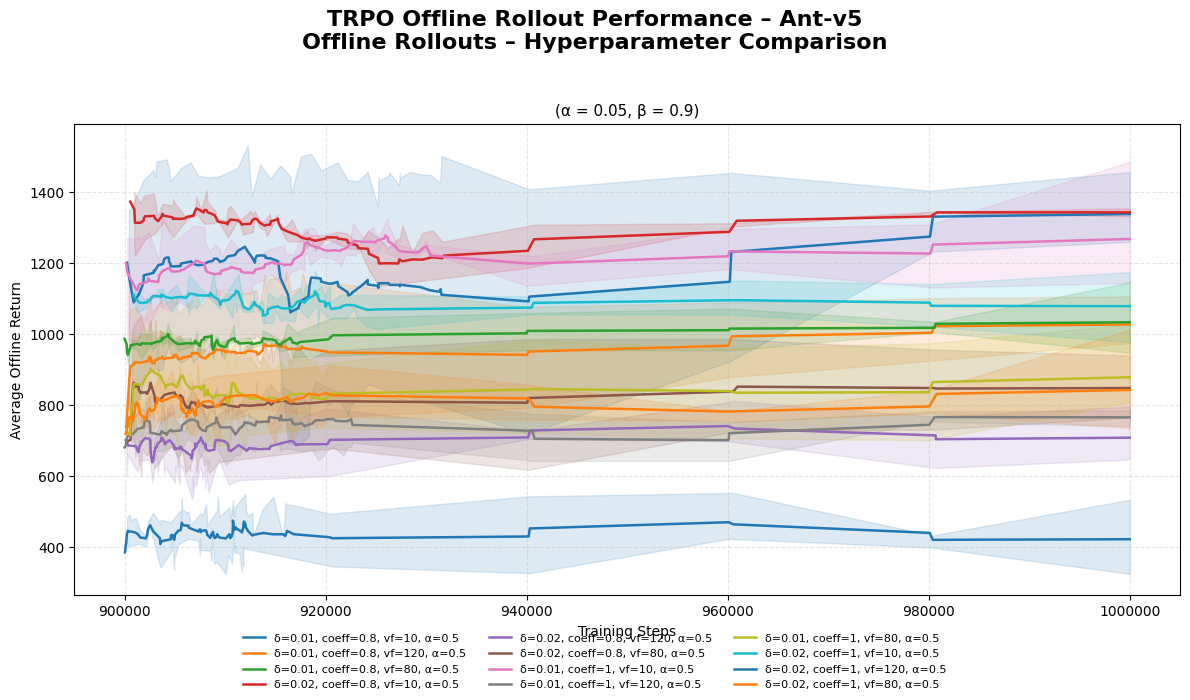

Found 32 PPO offline logs.
Found 16 unique PPO configs with offline evaluations.

📊 PPO Offline Evaluation Ranking – Ant-v5

Config                          Mean     Std    Mean/Std
clip=0.3, kl=0.02, pi=10, vf=10 1,766.37  63.17 27.96   
clip=0.2, kl=0.01, pi=20, vf=20 1,691.84  32.95 51.35   
clip=0.2, kl=0.01, pi=20, vf=10 1,660.98  54.18 30.65   
clip=0.3, kl=0.01, pi=10, vf=10 1,659.27  46.57 35.63   
clip=0.3, kl=0.01, pi=10, vf=20 1,657.46  50.55 32.79   
clip=0.2, kl=0.02, pi=10, vf=10 1,655.73  72.14 22.95   
clip=0.3, kl=0.01, pi=20, vf=10 1,632.47  70.67 23.10   
clip=0.3, kl=0.02, pi=20, vf=20 1,626.40  58.72 27.70   
clip=0.3, kl=0.01, pi=20, vf=20 1,612.41  65.14 24.75   
clip=0.3, kl=0.02, pi=10, vf=20 1,604.17 119.98 13.37   
clip=0.2, kl=0.02, pi=20, vf=20 1,583.01  74.20 21.33   
clip=0.2, kl=0.01, pi=10, vf=20 1,547.49  34.75 44.53   
clip=0.2, kl=0.02, pi=20, vf=10 1,526.06  76.72 19.89   
clip=0.3, kl=0.02, pi=20, vf=10 1,456.80  90.11 16.17   
clip=0.2, kl=0.02, p

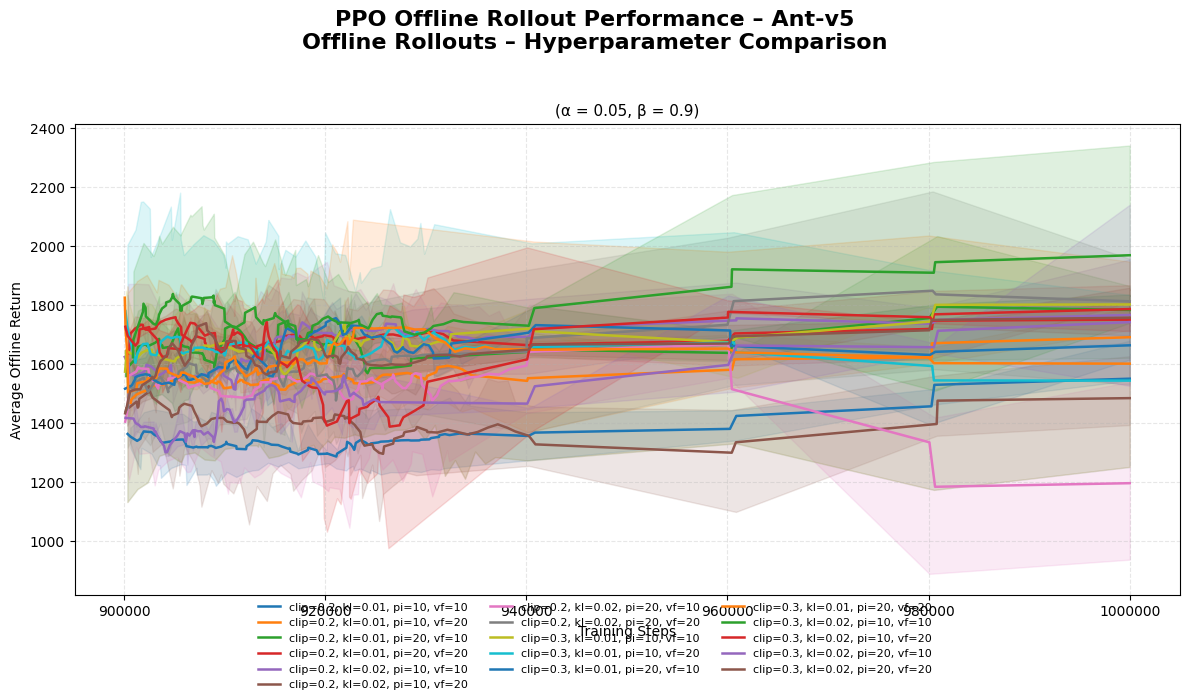

In [27]:
# Offline TRPO
df_trpo_chet_off, curves_trpo_chet_off = analyze_trpo_offline_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_chet",
    env_name="HalfCheetah-v5",
    subtitle="Offline Rollouts – Hyperparameter Comparison",
    save_fig=True,
)

# Offline PPO
df_ppo_chet_off, curves_ppo_chet_off = analyze_ppo_offline_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/ppo_chet",
    env_name="HalfCheetah-v5",
    subtitle="Offline Rollouts – Hyperparameter Comparison",
    save_fig=True,
)

df_trpo_ant_off, curves_trpo_ant_off = analyze_trpo_offline_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/trpo_ant",
    env_name="Ant-v5",
    subtitle="Offline Rollouts – Hyperparameter Comparison",
    save_fig=True,
)

# Offline PPO
df_ppo_ant_off, curves_ppo_ant_off = analyze_ppo_offline_logs(
    log_dir=r"C:/Users/Phong/OneDrive/Documents/VSCODEFILE/CMPUT665-PROJECT/analysis",
    env_name="Ant-v5",
    subtitle="Offline Rollouts – Hyperparameter Comparison",
    save_fig=True,
)